In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
import random
import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import train_test_split ,cross_val_score , KFold
from sklearn.metrics import r2_score
import sqlite3

pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)

In [ ]:
connection = sqlite3.connect("database.sqlite")

master_table = pd.read_sql("""SELECT * 
                    FROM sqlite_master
                    WHERE type='table';""", connection)

tables = master_table.tbl_name.to_list()
tables

In [ ]:
Player_Attributes = pd.read_sql_query("SELECT * from Player_Attributes " ,connection) 
Player = pd.read_sql_query("SELECT * from Player " ,connection)
Match = pd.read_sql_query("SELECT * from Match " ,connection)
League = pd.read_sql_query("SELECT * from League " ,connection)
Country = pd.read_sql_query("SELECT * from Country " ,connection)
Team = pd.read_sql_query("SELECT * from Team " ,connection)
Team_Attributes = pd.read_sql_query("SELECT * from Team_Attributes " ,connection)

In [ ]:
print('No of columns for player_attributes_table are :',len(Player_Attributes.columns))
print('\n')
print('No of columns for player_table are :',len(Player.columns))
print('\n')
print('No of columns for match_table are :',len(Match.columns))
print('\n')
print('No of columns for league_table are :',len(League.columns))
print('\n')
print('No of columns for country_table are :',len(Country.columns))
print('\n')
print('No of columns for team_table are :',len(Team.columns))
print('\n')
print('No of columns for team_attributes are :',len(Team_Attributes.columns))

In [ ]:
Player_Attributes = Player_Attributes.merge(Player , on= "player_api_id")

In [ ]:
Player_Attributes

In [ ]:
for i in range(Player_Attributes.shape[0]) :
    Player_Attributes.loc[i,"age"] = (int(Player_Attributes.loc[i,"date"].split("-")[0]) - int(Player_Attributes.loc[i,"birthday"].split("-")[0]))
    
Player_Attributes["age"] = Player_Attributes["age"].astype("int64")
Player_Attributes["height"] = Player_Attributes["height"].astype("int64")
Player_Attributes = Player_Attributes.drop("birthday" ,1)

In [ ]:
Player_Attributes

In [ ]:
Player_Attributes.drop_duplicates(subset ="player_name",
                     keep = "first", inplace = True)

In [ ]:
Player_Attributes.to_csv("Players.csv")

In [2]:
df = pd.read_csv("Players.csv")

In [3]:
df["overall_rating"].describe()

count    10848.000000
mean        67.931969
std          6.323781
min         42.000000
25%         64.000000
50%         68.000000
75%         72.000000
max         94.000000
Name: overall_rating, dtype: float64

In [4]:
df [df["overall_rating"] >= 85].shape

(56, 49)

<AxesSubplot:xlabel='overall_rating', ylabel='Count'>

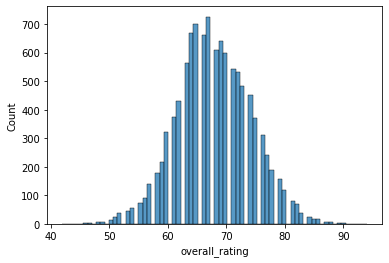

In [5]:
sns.histplot(data=df, x="overall_rating")

In [6]:
for i in range(df.shape[0]) :
    
    if (df.loc[i, "overall_rating"] >= 42.0) & (df.loc[i , "overall_rating"] < 85.0) :
        df.loc[i, "overall_rating"] = 0
        
    elif (df.loc[i, "overall_rating"] >= 85.0) :
        df.loc[i, "overall_rating"] = 1

df["overall_rating"] = df["overall_rating"].astype("int64")

In [7]:
df["attacking_work_rate"].fillna("medium", inplace = True)
col_list = ["volleys","curve","agility","balance","jumping","vision","sliding_tackle"]
for item in col_list :
    df[item].fillna(round(df[item].mean() , 0) , inplace = True)    

In [8]:
df.isnull().sum()

Unnamed: 0              0
id_x                    0
player_fifa_api_id_x    0
player_api_id           0
date                    0
overall_rating          0
potential               0
preferred_foot          0
attacking_work_rate     0
defensive_work_rate     0
crossing                0
finishing               0
heading_accuracy        0
short_passing           0
volleys                 0
dribbling               0
curve                   0
free_kick_accuracy      0
long_passing            0
ball_control            0
acceleration            0
sprint_speed            0
agility                 0
reactions               0
balance                 0
shot_power              0
jumping                 0
stamina                 0
strength                0
long_shots              0
aggression              0
interceptions           0
positioning             0
vision                  0
penalties               0
marking                 0
standing_tackle         0
sliding_tackle          0
gk_diving   

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10848 entries, 0 to 10847
Data columns (total 49 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            10848 non-null  int64  
 1   id_x                  10848 non-null  int64  
 2   player_fifa_api_id_x  10848 non-null  int64  
 3   player_api_id         10848 non-null  int64  
 4   date                  10848 non-null  object 
 5   overall_rating        10848 non-null  int64  
 6   potential             10848 non-null  float64
 7   preferred_foot        10848 non-null  object 
 8   attacking_work_rate   10848 non-null  object 
 9   defensive_work_rate   10848 non-null  object 
 10  crossing              10848 non-null  float64
 11  finishing             10848 non-null  float64
 12  heading_accuracy      10848 non-null  float64
 13  short_passing         10848 non-null  float64
 14  volleys               10848 non-null  float64
 15  dribbling          

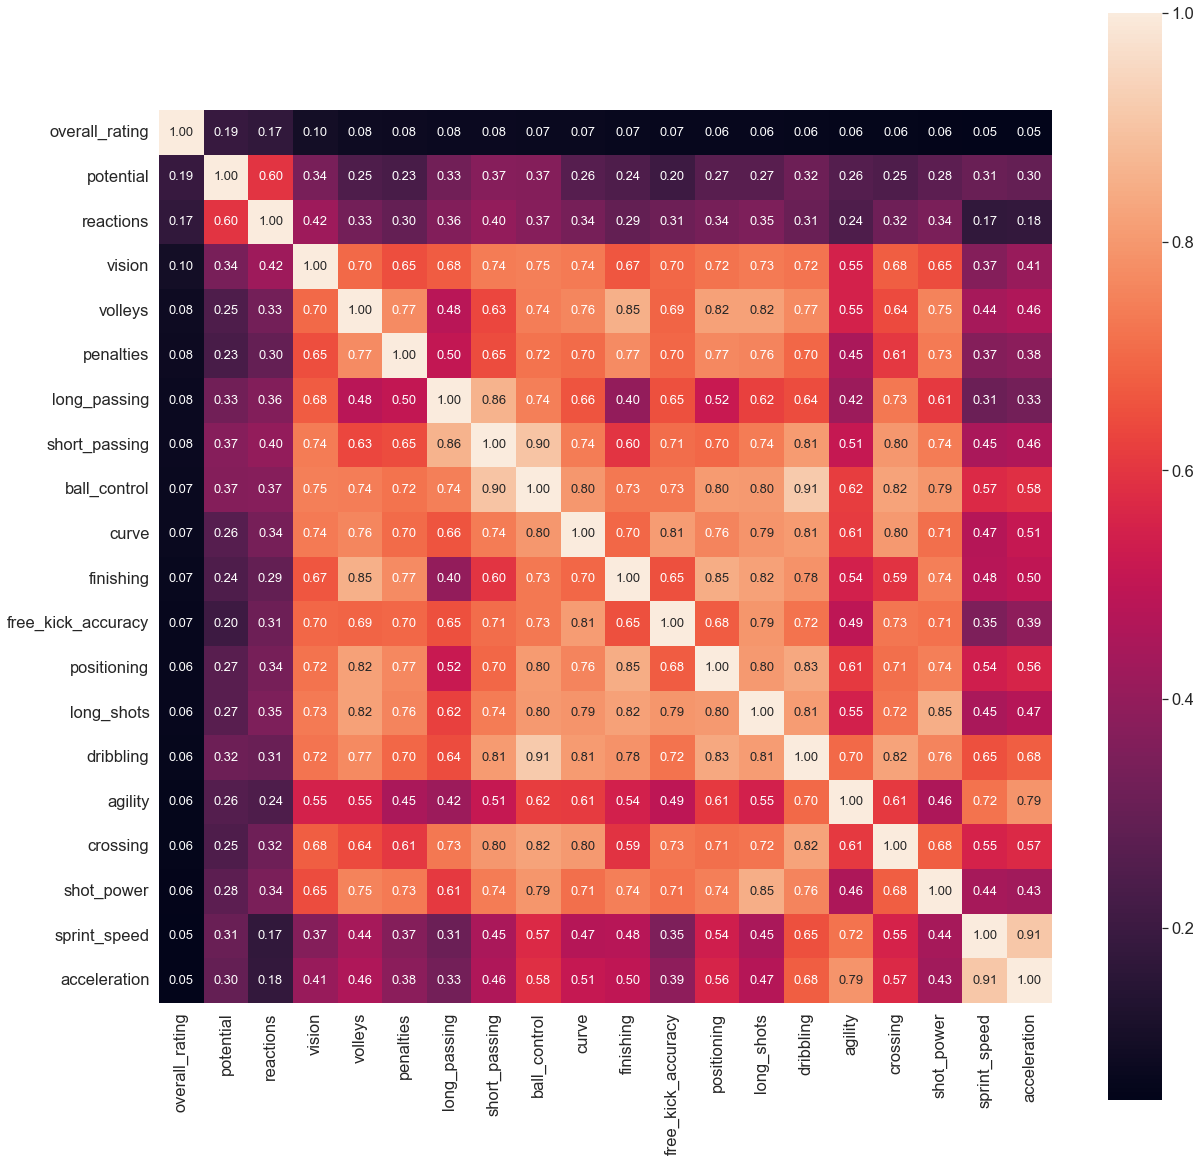

In [10]:
k = 20 #number of variables for heatmap
corrmat = df.corr()
cols = corrmat.nlargest(k, 'overall_rating')['overall_rating'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
plt.figure(figsize=(20,20))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 13}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [11]:
selected_columns = ["potential" , "reactions" , "short_passing" , "vision" , "long_passing" , "ball_control" , "shot_power" , "long_shots" , "curve" , "dribbling" , "crossing" , "volleys" , "positioning" , "free_kick_accuracy" , "penalties" ,        
"aggression" , "finishing" , "stamina" , "heading_accuracy"  , "overall_rating"]

modelling_df = df[selected_columns]

In [12]:
modelling_df

,potential,reactions,short_passing,vision,long_passing,ball_control,shot_power,long_shots,curve,dribbling,crossing,volleys,positioning,free_kick_accuracy,penalties,aggression,finishing,stamina,heading_accuracy,overall_rating
0,71.0,47.0,61.0,54.0,64.0,49.0,55.0,35.0,45.0,51.0,49.0,44.0,45.0,39.0,48.0,71.0,44.0,54.0,71.0,0
1,76.0,67.0,71.0,66.0,68.0,71.0,71.0,62.0,70.0,73.0,80.0,40.0,60.0,69.0,59.0,68.0,53.0,79.0,58.0,0
2,67.0,51.0,66.0,68.0,62.0,67.0,61.0,57.0,67.0,66.0,64.0,52.0,64.0,63.0,61.0,60.0,58.0,66.0,60.0,0
3,69.0,57.0,65.0,54.0,61.0,62.0,59.0,29.0,38.0,56.0,57.0,48.0,26.0,40.0,37.0,70.0,21.0,49.0,68.0,0
4,70.0,68.0,65.0,41.0,58.0,58.0,48.0,26.0,42.0,47.0,46.0,33.0,29.0,25.0,45.0,66.0,34.0,60.0,73.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10843,73.0,68.0,70.0,52.0,53.0,63.0,57.0,30.0,49.0,54.0,42.0,30.0,22.0,33.0,50.0,75.0,27.0,54.0,74.0,0
10844,67.0,65.0,63.0,49.0,63.0,61.0,30.0,31.0,67.0,57.0,65.0,49.0,49.0,64.0,53.0,67.0,44.0,77.0,59.0,0
10845,73.0,69.0,66.0,66.0,60.0,67.0,59.0,53.0,60.0,65.0,64.0,57.0,58.0,44.0,61.0,78.0,38.0,70.0,71.0,0
10846,78.0,62.0,59.0,63.0,51.0,61.0,50.0,46.0,29.0,36.0,48.0,59.0,28.0,37.0,45.0,71.0,43.0,68.0,79.0,0


In [13]:
modelling_df["overall_rating"].value_counts()

0    10792
1       56
Name: overall_rating, dtype: int64

D:\Program Files\Python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='overall_rating', ylabel='count'>

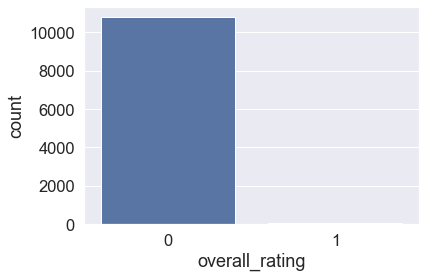

In [14]:
sns.countplot(modelling_df['overall_rating'])

In [15]:
trainData = modelling_df.tail(8678)
testData =  modelling_df.head(2170)

In [16]:
X = trainData.drop("overall_rating", 1)
y = trainData.overall_rating

X_test = testData.drop("overall_rating", 1)
y_test = testData.overall_rating

sc = StandardScaler()

X = pd.DataFrame(sc.fit_transform(X))
X_test = pd.DataFrame(sc.transform(X_test))

C:\Users\Ugur\AppData\Local\Temp/ipykernel_19960/944480452.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = trainData.drop("overall_rating", 1)
C:\Users\Ugur\AppData\Local\Temp/ipykernel_19960/944480452.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test = testData.drop("overall_rating", 1)


In [17]:
oversample = SMOTE( random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25,  random_state =42)
X_over, y_over = oversample.fit_resample(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_over, y_over, test_size = 0.25, random_state = 42)

D:\Program Files\Python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='overall_rating', ylabel='count'>

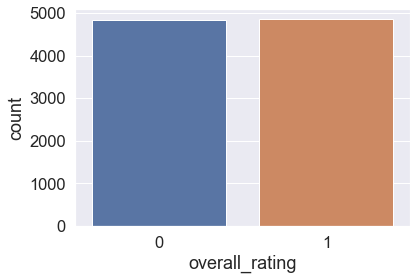

In [18]:
chck = pd.DataFrame()
chck['overall_rating'] = y_train
sns.countplot(chck['overall_rating'])

99.66007416563659
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1626
           1       0.99      1.00      1.00      1610

    accuracy                           1.00      3236
   macro avg       1.00      1.00      1.00      3236
weighted avg       1.00      1.00      1.00      3236



<AxesSubplot:>

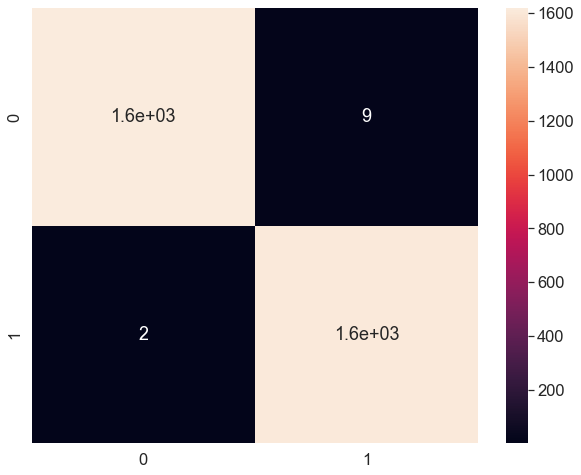

In [19]:
dtc=DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
preds = dtc.predict(X_val)
score = dtc.score(X_val, y_val)
print(score*100)
print(classification_report(y_val, preds))
cm = confusion_matrix(y_val, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True)

99.35483870967742
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2160
           1       0.39      0.70      0.50        10

    accuracy                           0.99      2170
   macro avg       0.69      0.85      0.75      2170
weighted avg       1.00      0.99      0.99      2170



<AxesSubplot:>

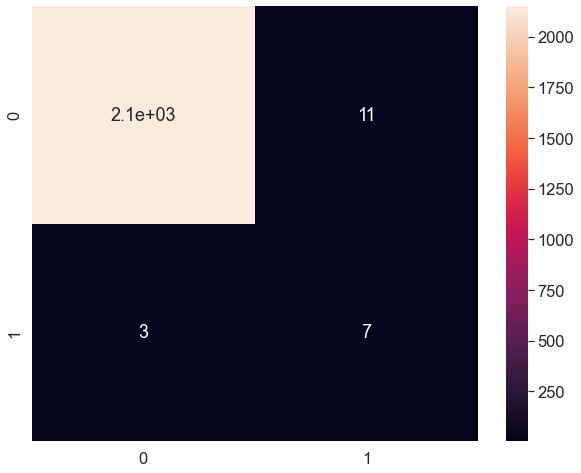

In [20]:
preds = dtc.predict(X_test)
score = dtc.score(X_test, y_test)
print(score*100)
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True)

99.53646477132261
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1626
           1       0.99      1.00      1.00      1610

    accuracy                           1.00      3236
   macro avg       1.00      1.00      1.00      3236
weighted avg       1.00      1.00      1.00      3236



<AxesSubplot:>

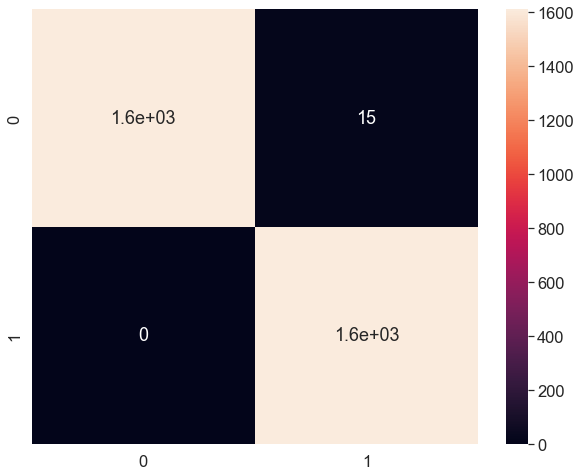

In [21]:
lgr=LogisticRegression(random_state=42 , max_iter = 200)
lgr.fit(X_train, y_train)
preds = lgr.predict(X_val)
score = lgr.score(X_val, y_val)
print(score*100)
print(classification_report(y_val, preds))
cm = confusion_matrix(y_val, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True)

99.07834101382488
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2160
           1       0.33      1.00      0.50        10

    accuracy                           0.99      2170
   macro avg       0.67      1.00      0.75      2170
weighted avg       1.00      0.99      0.99      2170



<AxesSubplot:>

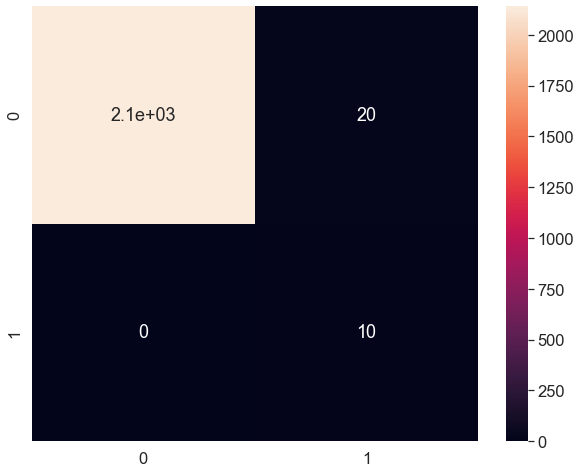

In [22]:
preds = lgr.predict(X_test)
score = lgr.score(X_test, y_test)
print(score*100)
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True)

99.87639060568603
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1626
           1       1.00      1.00      1.00      1610

    accuracy                           1.00      3236
   macro avg       1.00      1.00      1.00      3236
weighted avg       1.00      1.00      1.00      3236



<AxesSubplot:>

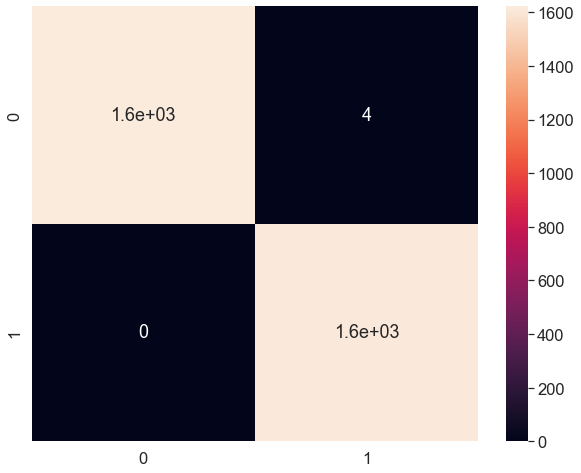

In [23]:
rfc = RandomForestClassifier(random_state=42)
# Fit
rfc.fit(X_train, y_train)

# Predict
preds = rfc.predict(X_val)
score = rfc.score(X_val, y_val)
print(score*100)
print(classification_report(y_val, preds))
cm = confusion_matrix(y_val, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True)

99.63133640552996
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2160
           1       0.56      0.90      0.69        10

    accuracy                           1.00      2170
   macro avg       0.78      0.95      0.85      2170
weighted avg       1.00      1.00      1.00      2170



<AxesSubplot:>

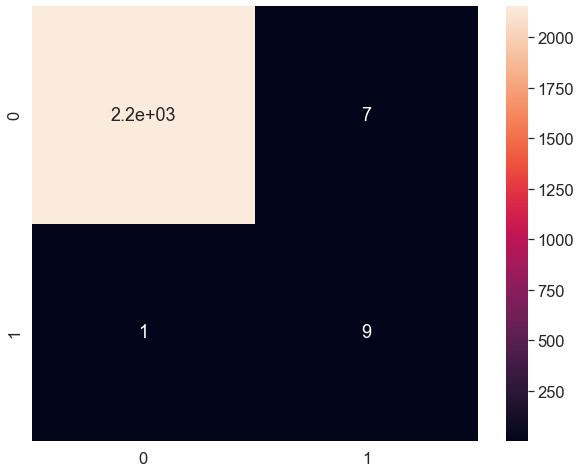

In [24]:
preds = rfc.predict(X_test)
score = rfc.score(X_test, y_test)
print(score*100)
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True)

99.78368355995056
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1626
           1       1.00      1.00      1.00      1610

    accuracy                           1.00      3236
   macro avg       1.00      1.00      1.00      3236
weighted avg       1.00      1.00      1.00      3236



<AxesSubplot:>

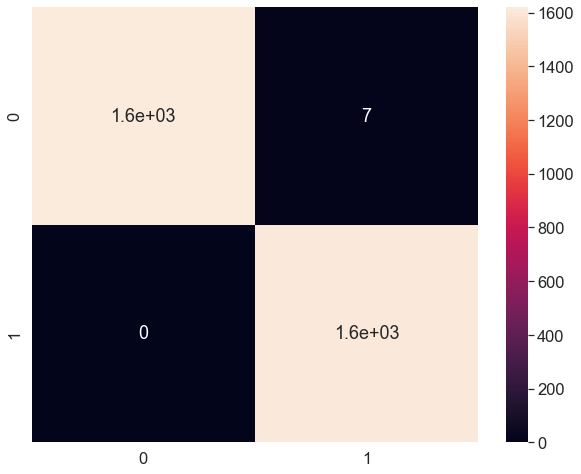

In [25]:
cbc=CatBoostClassifier(n_estimators = 200, max_depth = 5, verbose = 0 , random_state=42)
cbc.fit(X_train, y_train)
preds = cbc.predict(X_val)
score = cbc.score(X_val, y_val)
print(score*100)
print(classification_report(y_val, preds))
cm = confusion_matrix(y_val, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True)

99.44700460829493
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2160
           1       0.45      1.00      0.62        10

    accuracy                           0.99      2170
   macro avg       0.73      1.00      0.81      2170
weighted avg       1.00      0.99      1.00      2170



<AxesSubplot:>

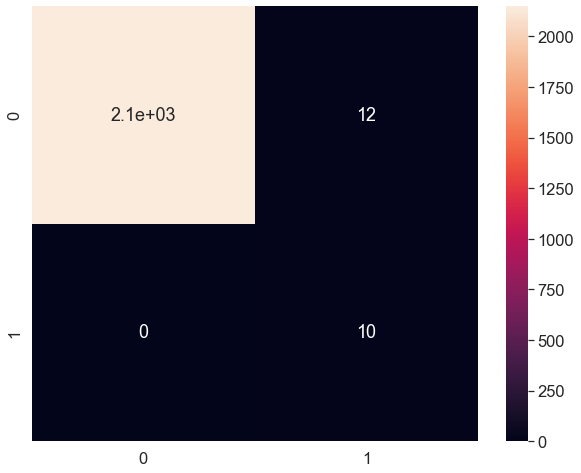

In [26]:
preds = cbc.predict(X_test)
score = cbc.score(X_test, y_test)
print(score*100)
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True)

D:\Program Files\Python\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


99.81458590852905
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1626
           1       1.00      1.00      1.00      1610

    accuracy                           1.00      3236
   macro avg       1.00      1.00      1.00      3236
weighted avg       1.00      1.00      1.00      3236



<AxesSubplot:>

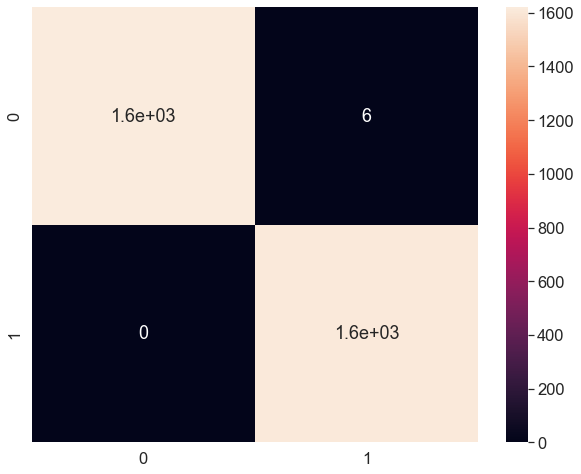

In [27]:
clf = LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.10,
        num_leaves=30,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
clf.fit(X_train, y_train)
preds = clf.predict(X_val)
score = clf.score(X_val, y_val)
print(score*100)
print(classification_report(y_val, preds))
cm = confusion_matrix(y_val, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True)

99.53917050691244
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2160
           1       0.50      0.90      0.64        10

    accuracy                           1.00      2170
   macro avg       0.75      0.95      0.82      2170
weighted avg       1.00      1.00      1.00      2170



<AxesSubplot:>

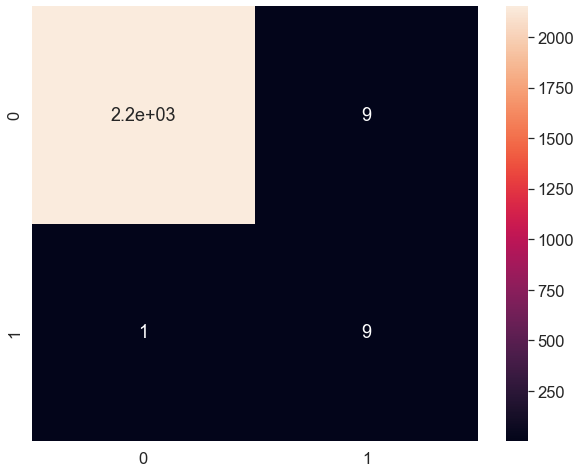

In [28]:
preds = clf.predict(X_test)
score = clf.score(X_test, y_test)
print(score*100)
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True)

D:\Program Files\Python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:34:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimator", "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:34:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
99.78368355995056
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1626
           1       1.00      1.00      1.00      1610

    accuracy                           1.00      3236
   macro avg       1.00      1.00      1.00      

<AxesSubplot:>

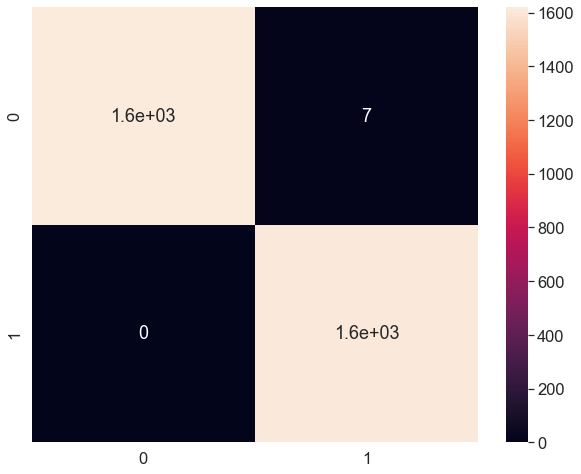

In [29]:
xgb_clf = XGBClassifier(n_estimator = 300,
                    learning_rate=0.10,
                    num_leaves=30)

xgb_clf.fit(X_train, y_train)
preds = xgb_clf.predict(X_val)
score = xgb_clf.score(X_val, y_val)
print(score*100)
print(classification_report(y_val, preds))
cm = confusion_matrix(y_val, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True)

99.53917050691244
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2160
           1       0.50      1.00      0.67        10

    accuracy                           1.00      2170
   macro avg       0.75      1.00      0.83      2170
weighted avg       1.00      1.00      1.00      2170



<AxesSubplot:>

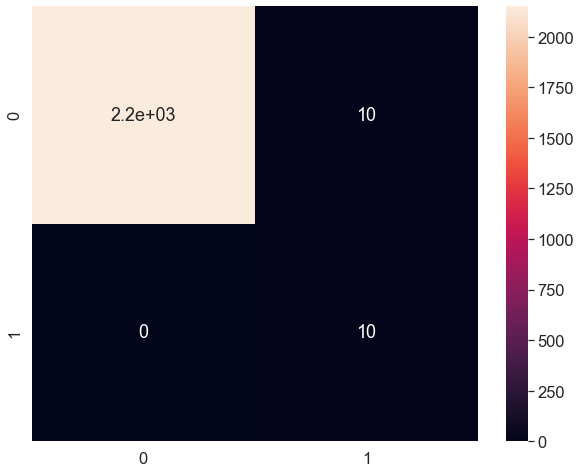

In [30]:
preds = xgb_clf.predict(X_test)
score = xgb_clf.score(X_test, y_test)
print(score*100)
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True)

## TRAINING WITH %80 OF DATA AND TESTING ON %20 OF DATA

In [31]:
trainData1 = modelling_df.head(8678)
testData1 =  modelling_df.tail(2170)

In [32]:
X = trainData1.drop("overall_rating", 1)
y = trainData1.overall_rating

X_test = testData1.drop("overall_rating", 1)
y_test = testData1.overall_rating

sc = StandardScaler()

X = pd.DataFrame(sc.fit_transform(X))
X_test = pd.DataFrame(sc.transform(X_test))

oversample = SMOTE( random_state=42)
X_train, y_train = oversample.fit_resample(X, y)

C:\Users\Ugur\AppData\Local\Temp/ipykernel_19960/301081656.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = trainData1.drop("overall_rating", 1)
C:\Users\Ugur\AppData\Local\Temp/ipykernel_19960/301081656.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test = testData1.drop("overall_rating", 1)


99.5852534562212
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2155
           1       0.71      0.67      0.69        15

    accuracy                           1.00      2170
   macro avg       0.86      0.83      0.84      2170
weighted avg       1.00      1.00      1.00      2170



<AxesSubplot:>

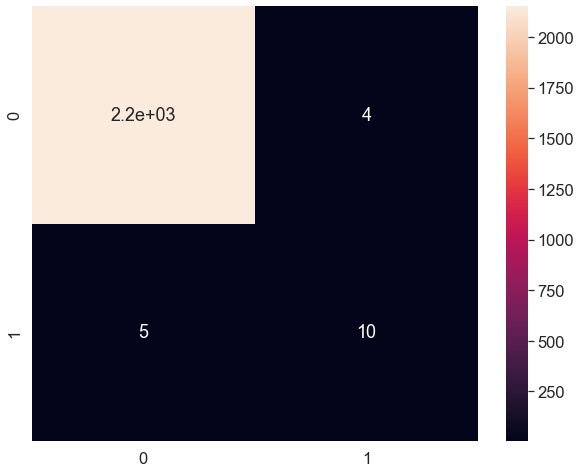

In [33]:
dtc=DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
preds = dtc.predict(X_test)
score = dtc.score(X_test, y_test)
print(score*100)
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True)

99.30875576036865
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2155
           1       0.50      0.93      0.65        15

    accuracy                           0.99      2170
   macro avg       0.75      0.96      0.82      2170
weighted avg       1.00      0.99      0.99      2170



<AxesSubplot:>

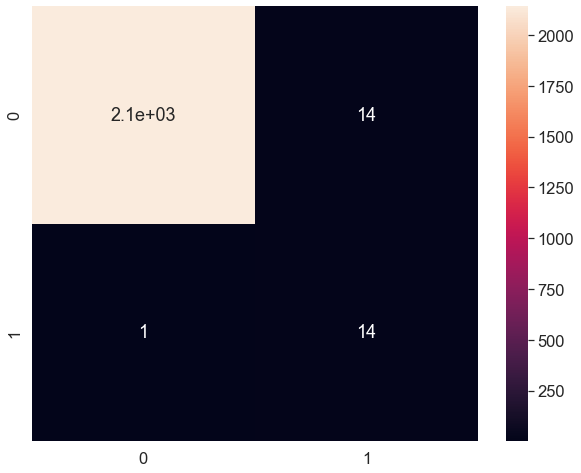

In [34]:
lgr=LogisticRegression(random_state=42 , max_iter = 100)
lgr.fit(X_train, y_train)
preds = lgr.predict(X_test)
score = lgr.score(X_test, y_test)
print(score*100)
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True)

99.72350230414746
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2155
           1       0.74      0.93      0.82        15

    accuracy                           1.00      2170
   macro avg       0.87      0.97      0.91      2170
weighted avg       1.00      1.00      1.00      2170



<AxesSubplot:>

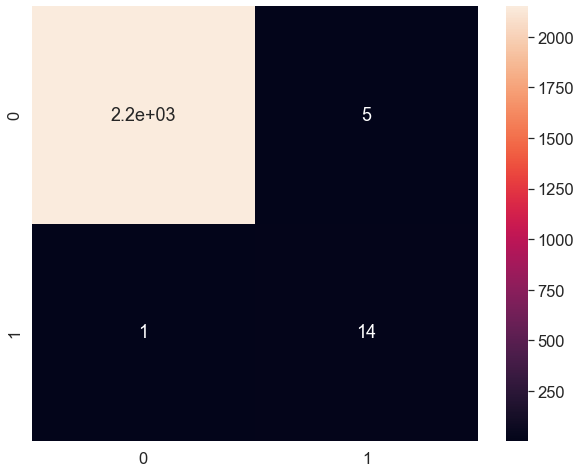

In [35]:
rfc = RandomForestClassifier(n_estimators=200 , max_depth=6 , random_state=42)
# Fit
rfc.fit(X_train, y_train)

# Predict
preds = rfc.predict(X_test)
score = rfc.score(X_test, y_test)
print(score*100)
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True)

99.86175115207374
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2155
           1       0.93      0.87      0.90        15

    accuracy                           1.00      2170
   macro avg       0.96      0.93      0.95      2170
weighted avg       1.00      1.00      1.00      2170



<AxesSubplot:>

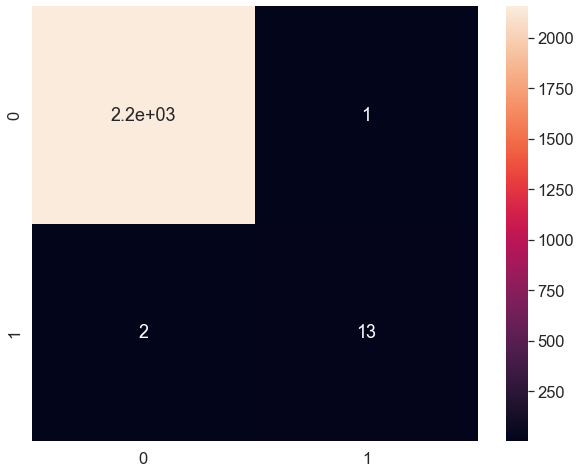

In [36]:
cbc=CatBoostClassifier(n_estimators = 400, max_depth = 3, verbose = 0 , random_state=42)
cbc.fit(X_train, y_train)
preds = cbc.predict(X_test)
score = cbc.score(X_test, y_test)
print(score*100)
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True)

99.86175115207374
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2155
           1       0.93      0.87      0.90        15

    accuracy                           1.00      2170
   macro avg       0.96      0.93      0.95      2170
weighted avg       1.00      1.00      1.00      2170



D:\Program Files\Python\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


<AxesSubplot:>

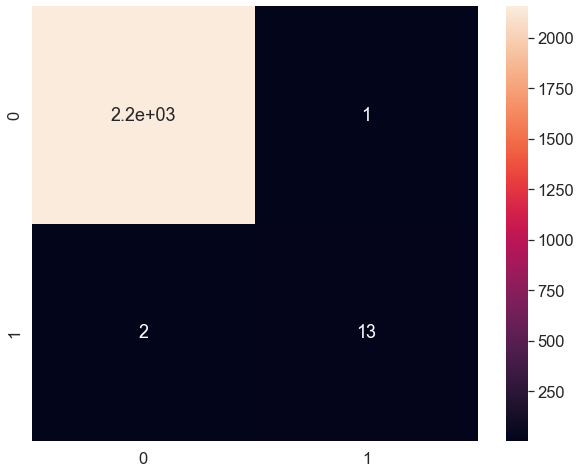

In [37]:
clf = LGBMClassifier(
        n_estimators=200,
        learning_rate=0.3,
        num_leaves=30,
        subsample=.9,
        max_depth=2,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
score = clf.score(X_test, y_test)
print(score*100)
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True)

D:\Program Files\Python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:35:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimator", "num_leaves" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
99.72350230414746
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2155
           1       0.85      0.73      0.79        15

    accuracy                           1.00      2170
   macro avg       0.92      0.87      0.89      

<AxesSubplot:>

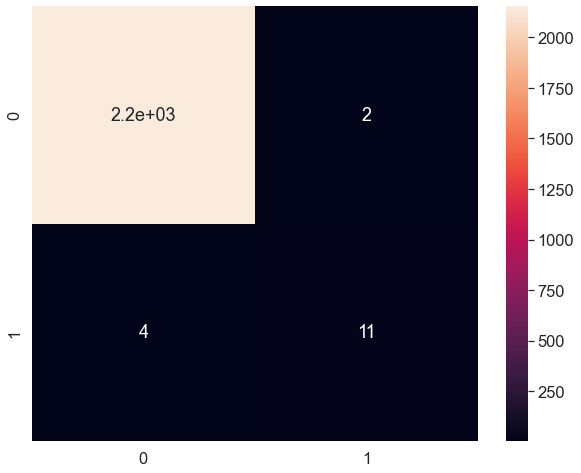

In [38]:
xgb_clf = XGBClassifier(n_estimator = 300,
                    learning_rate=0.2,
                    num_leaves=30)

xgb_clf.fit(X_train, y_train)
preds = xgb_clf.predict(X_test)
score = xgb_clf.score(X_test, y_test)
print(score*100)
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True)

In [109]:
X1 = modelling_df.drop("overall_rating", 1)
y1 = modelling_df.overall_rating

kf = KFold(n_splits=4, shuffle=True, random_state = 42)
print(np.mean(cross_val_score(clf, X1, y1, cv=kf, scoring='precision' , n_jobs= -1)))
print(np.mean(cross_val_score(clf, X1, y1, cv=kf, scoring='recall' , n_jobs= -1)))
print(np.mean(cross_val_score(clf, X1, y1, cv=kf, scoring='f1' , n_jobs= -1)))

C:\Users\Ugur\AppData\Local\Temp/ipykernel_19960/3821436725.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X1 = modelling_df.drop("overall_rating", 1)


0.8383838383838383
0.7452214452214452
0.7853091588510464


In [124]:
kf1 = KFold(n_splits=7, shuffle=True, random_state = 42)
print(np.mean(cross_val_score(xgb_clf, X1, y1, cv=kf1, scoring='precision' , n_jobs= -1)))
print(np.mean(cross_val_score(xgb_clf, X1, y1, cv=kf1, scoring='recall' , n_jobs= -1)))
print(np.mean(cross_val_score(xgb_clf, X1, y1, cv=kf1, scoring='f1' , n_jobs= -1)))

0.7838304552590267
0.7707482993197278
0.7723976023976025


In [139]:
kf2 = KFold(n_splits=10, shuffle=True, random_state = 42)
print(np.mean(cross_val_score(cbc, X1, y1, cv=kf2, scoring='precision')))
print(np.mean(cross_val_score(cbc, X1, y1, cv=kf2, scoring='recall')))
print(np.mean(cross_val_score(cbc, X1, y1, cv=kf2, scoring='f1')))

0.8391666666666667
0.7016666666666667
0.7528143425202248


In [147]:
kf3 = KFold(n_splits=7, shuffle=True, random_state = 42)
print(np.mean(cross_val_score(rfc, X1, y1, cv=kf3, scoring='precision')))
print(np.mean(cross_val_score(rfc, X1, y1, cv=kf3, scoring='recall')))
print(np.mean(cross_val_score(rfc, X1, y1, cv=kf3, scoring='f1')))

D:\Program Files\Python\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8095238095238094
0.5056689342403627
0.6076399790685505


In [153]:
kf4 = KFold(n_splits=2, shuffle=True, random_state = 42)
print(np.mean(cross_val_score(lgr, X1, y1, cv=kf4, scoring='precision')))
print(np.mean(cross_val_score(lgr, X1, y1, cv=kf4, scoring='recall')))
print(np.mean(cross_val_score(lgr, X1, y1, cv=kf4, scoring='f1')))

D:\Program Files\Python\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Program Files\Python\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

0.4149305555555556
0.3909677419354839
0.3944911297852475


D:\Program Files\Python\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [165]:
kf5 = KFold(n_splits=7, shuffle=True, random_state = 42)
print(np.mean(cross_val_score(dtc, X1, y1, cv=kf5, scoring='precision')))
print(np.mean(cross_val_score(dtc, X1, y1, cv=kf5, scoring='recall')))
print(np.mean(cross_val_score(dtc, X1, y1, cv=kf5, scoring='f1')))

0.6041666666666666
0.7180272108843537
0.654011254851591
